In [3]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
from icecream import ic
from tqdm import tqdm
from get_data import *
from dataloader import *
from test_function import test
from NN_classes import *

# Use the GPU if available
torch.set_default_dtype(torch.float64)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device="cpu"
print(device)

cpu


index exceeds number of initial conditions -> random value chosen


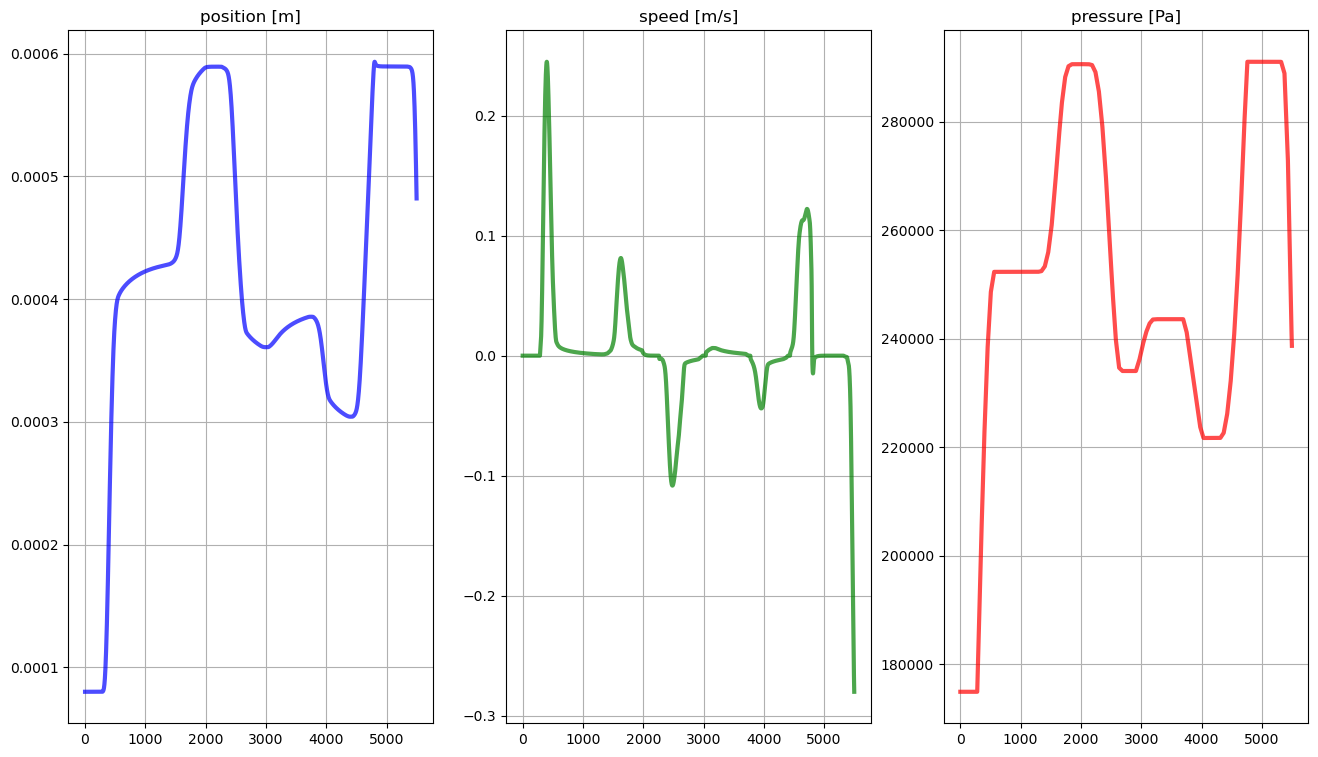

In [26]:
# Import the data generated via matlab/simulink:

data_tensor, PSW_max = get_data(path = r"data\save_data_test_5xlonger.csv", timesteps_from_data=0, skip_steps_start = 0,
                                 skip_steps_end = 0, drop_half_timesteps = False, normalise_s_w=None, rescale_p=False, num_inits=0)

# View an example of a simulation run
visualise(data_tensor, num_inits=9000)

In [ ]:
# Save the model
#path = f"Ventil_trained_NNs\lstm_ws0.pth"
#torch.save(model.state_dict(), path)

# Load the model and test it on the test data
path = "working_networks\OR_MLP_5_24_3.pth"

params =                                                    {
                            "experiment_number" : 2,
                           "window_size" : 20,
                           "h_size" : 24,
                           "l_num" : 3,
                           "epochs" : 500,
                           "learning_rate" : 0.001,
                           "part_of_data" : 100, 
                           "weight_decay" : 1e-5,
                           "percentage_of_data" : 0.8,
                           "batch_size" : 200,
                           "cut_off_timesteps" : 0,
                           "drop_half_timesteps": True,
                           "act_fn" : "relu",
                           "nonlin_at_out" : None #None if no nonlinearity at the end
                        }

# Generate input data (the data is normalized and some timesteps are cut off)
input_data1, PSW_max = get_data(path = "data\save_data_test_5xlonger.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data2, PSW_max = get_data(path = "data\save_data_test_revised.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

#input_data = torch.cat((input_data1, input_data2))
input_data = input_data2
print(input_data.size())

#Split data into train and test sets
np.random.seed(1234)
num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])

train_data = input_data[train_inits,:input_data.size(dim=1)-params["cut_off_timesteps"],:]
test_data = input_data[test_inits,:,:]
np.random.seed()

# dataloader for batching during training
train_set = CustomDataset_mlp(train_data, window_size=params["window_size"])
train_loader = DataLoader(train_set, batch_size=params["batch_size"])#, pin_memory=True)


model = OR_MLP(input_size=3*params["window_size"], hidden_size = params["h_size"], l_num=params["l_num"], 
               output_size=2, act_fn = params["act_fn"], act_at_end = params["nonlin_at_out"], timesteps=params["window_size"]).to(device)
model.load_state_dict(torch.load(path, map_location=torch.device(device)))
                                 
train_data = input_data[train_inits,:,:]

#test_loss, test_loss_deriv, total_loss = test(test_data, model, steps=input_data.size(dim=1), ws=params["window_size"], plot_opt=True , n = 8, test_inits=len(test_data), rand=False, PSW_max=PSW_max)

test_loss, test_loss_deriv, total_loss = test(test_data.to(device), model, model_type = "or_mlp", window_size=params["window_size"],
                                               display_plots=True, num_of_inits = 1, set_rand_seed=False, physics_rescaling = PSW_max)


In [ ]:
input_data.get_device()

In [ ]:

                        #           {
                        #     "experiment_number" : 2,
                        #    "window_size" : 5,
                        #    "h_size" : 8,
                        #    "l_num" : 1,
                        #    "epochs" : 500,
                        #    "learning_rate" : 0.001,
                        #    "part_of_data" : 100, 
                        #    "weight_decay" : 1e-5,
                        #    "percentage_of_data" : 0.8,
                        #    "batch_size" : 200,
                        #    "cut_off_timesteps" : 0,
                        #    "drop_half_timesteps": True,
                        #    "act_fn" : "relu",
                        #    "nonlin_at_out" : None #None if no nonlinearity at the end
                        # }

import torch
from torchviz import make_dot
from IPython.display import Image

x = next(iter(train_loader))[0]
y = model(x)
print(input_data2[0:1].size())
dot = make_dot(y, params=dict(model.named_parameters()),  show_attrs=True, show_saved=True)   # .render("model_graph", format="png")

#print(list(model.parameters()))

#calc 
erg=0
for a in list(model.parameters()):
    x = 1 
    for y in list(a.size()):
        x = x*y
    erg += x

print("anzahl der variablen" , erg)
# Remove autograd related nodes
#dot.attr(rankdir='LR')
dot.node_attr.update(style='filled')

# for node in dot.body:
#     if 'Backward' in node:
#         dot.body.remove(node)


dot
# Save the graph to a file
# dot.format = 'png'
# dot.render('model_graph')

# Display the graph in the Jupyter notebook
#Image(filename='model_graph.png')

In [ ]:
# Multilayer perceptron
class OR_MLP(nn.Module):
    
    def __init__(self, input_size=3, hidden_size = 6, l_num=1, output_size=2, act_fn="tanh", act_at_end = None, timesteps=5):
        super(OR_MLP, self).__init__()
        
        if act_fn == "tanh":
            fn = nn.Tanh()
        else:
            fn = nn.ReLU()

        hidden_sizes = [hidden_size for x in range(l_num)]
        # Create a list to hold the layers
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(fn)
        
        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(fn)
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        #Try final non linearity:
        if act_at_end != None:
            if act_at_end == "tanh":
                layers.append(nn.Tanh())
            if act_at_end == "relu":
                layers.append(nn.ReLU())
            if act_at_end == "sigmoid":
                layers.append(nn.Sigmoid())
        
        # Use nn.Sequential to put together the layers
        self.network = nn.Sequential(*layers)
        self.ws = timesteps
        #self.timesteps = timesteps
    
    def forward(self, one_full_traj):
        
        seq = one_full_traj[:, 0:self.ws, :]

        #inp = torch.cat((seq[:, :self.ws,0], seq[:, :self.ws,1], seq[:, :self.ws,2]), dim=2)
        inp = torch.stack([torch.cat((a[:, 0], a[:, 1], a[:, 2])) for a in seq])
        pred = self.network(inp) 
        
        out = one_full_traj[:, self.ws-1:self.ws, 1:] + pred.view(one_full_traj.size(dim=0),1,2)
        print("input", inp)
        print("pred", pred)
        print("outout", out)

        for t in range(1, self.ws): # für RK : range(1, self.ws + 2):


            tmp = torch.cat((one_full_traj[:,self.ws+(t-1):self.ws+(t-1)+(out.size(dim=1)), 0:1] , out[:, :, :]), dim=2)
            seq = torch.cat((one_full_traj[:, t:self.ws, :], tmp), dim=1)

            inp = torch.stack([torch.cat((a[:, 0], a[:, 1], a[:, 2])) for a in seq])

            pred = self.network(inp)

            out = torch.cat((out, out[:, -1:, 1:] + pred.view(one_full_traj.size(dim=0),1,2)), dim=1)
            print("input", inp)
            print("pred", pred)
            print("outout", out)

        for t in range(self.ws, one_full_traj.size(dim=1) - self.ws):

            seq = torch.cat((one_full_traj[:, t : t + self.ws, 0:1], out[:, t - self.ws : t , :]), dim=2)
            
            inp = torch.stack([torch.cat((a[:, 0], a[:, 1], a[:, 2])) for a in seq])

            pred = self.network(inp)

            out = torch.cat((out, out[:, -1:, 1:] + pred.view(one_full_traj.size(dim=0),1,2)), dim=1)
            print("input", inp)
            print("pred", pred)
            print("outout", out)
        return out        




In [ ]:
# Save the model
#path = f"Ventil_trained_NNs\lstm_ws0.pth"
#torch.save(model.state_dict(), path)


params =                                                    {
                            "experiment_number" : 2,
                           "window_size" : 5,
                           "h_size" : 8,
                           "l_num" : 1,
                           "epochs" : 500,
                           "learning_rate" : 0.001,
                           "part_of_data" : 100, 
                           "weight_decay" : 1e-5,
                           "percentage_of_data" : 0.8,
                           "batch_size" : 200,
                           "cut_off_timesteps" : 0,
                           "drop_half_timesteps": True,
                           "act_fn" : "relu",
                           "nonlin_at_out" : None #None if no nonlinearity at the end
                        }

# Generate input data (the data is normalized and some timesteps are cut off)
input_data1, PSW_max = get_data(path = "data\save_data_test_5xlonger.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])


input_data = input_data1
print(input_data.size())

#Split data into train and test sets
np.random.seed(1234)
num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])

train_data = input_data[train_inits,:input_data.size(dim=1)-params["cut_off_timesteps"],:]
test_data = input_data[test_inits,:,:]
np.random.seed()

# dataloader for batching during training
train_set = CustomDataset_mlp(train_data, window_size=params["window_size"])
train_loader = DataLoader(train_set, batch_size=params["batch_size"])#, pin_memory=True)


model = OR_MLP(input_size=3*params["window_size"], hidden_size = params["h_size"], l_num=params["l_num"], output_size=2, act_fn = params["act_fn"], act_at_end = params["nonlin_at_out"]).to(device)
                              


In [ ]:
input_data_new = input_data[0:3,0:15:,:].clone()
input_data_new[0:1,:,0:1] = 1
input_data_new[0:1,:,1:2] = 2
input_data_new[0:1,:,2:] = 3
input_data_new[1:2,:,0:1] = 4
input_data_new[1:2,:,1:2] = 5
input_data_new[1:2,:,2:] = 6
input_data_new[2:,:,0:1] = 7
input_data_new[2:,:,1:2] = 8
input_data_new[2:,:,2:] = 9

model(input_data_new)
